In [1]:
# Connect do drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import time
import gc
import math

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install hdf5storage
import hdf5storage
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.fft import fft, fftfreq, fft2, rfft
from scipy.signal import iirnotch, freqz
from scipy.signal import spectrogram

import keras
import shap

In [ ]:
cnn_model_file = "/content/drive/MyDrive/grid_search_84.h5"
cnn_model = keras.models.load_model(cnn_model_file)

In [ ]:
shap_values.shape

(10, 101, 4, 256, 9)

In [ ]:
# Top channels per class

# shap_values shape: (1, 101, 4, 256, 9) → Select first sample (axis 0)
shap_per_class = np.moveaxis(shap_values, -1, 0)  # Shape: (9, 101, 4, 256)

# Sum absolute SHAP values for each class and channel
channel_importance = np.sum(np.abs(shap_per_class), axis=(1, 2, 3))  # Shape: (9, 256)
channel_importance /= len(shap_values)

# Rank channels by importance (descending)
top_channels_per_class = {
    f"Class {i}": np.argsort(-channel_importance[i])[:10]  # Top 5 channels
    for i in range(9)
}
print("Top channels per class:", top_channels_per_class)

Top channels per class: {'Class 0': array([77, 76, 79,  9, 69, 81, 71, 80, 13, 66]), 'Class 1': array([77, 76, 79,  9, 13, 80, 69, 71, 81, 70]), 'Class 2': array([77, 76, 79,  9, 69, 71, 81, 66, 80, 13]), 'Class 3': array([77, 76, 79,  9, 81, 71, 69,  8, 92, 86]), 'Class 4': array([77,  9, 76, 79, 69, 81, 71, 13, 20, 80]), 'Class 5': array([ 76,  79,  77,  34,  81,   9,  92,  80,  69, 132]), 'Class 6': array([76, 77, 79, 69, 81, 80, 71, 64,  9, 70]), 'Class 7': array([77, 76,  9, 79, 81, 71, 69, 80, 13, 70]), 'Class 8': array([77, 76,  9, 79, 71, 81, 13, 69, 80, 72])}


In [ ]:
# Ablation tests for individual channels

top_channel = np.argmax(channel_importance[0])  # Most important for Class 0
X_test_ablated = X_test.copy()
X_test_ablated[..., top_channel] = 0  # Ablate channel
accuracy_drop = keras_model.evaluate(X_test, y_test)[1] - keras_model.evaluate(X_test_ablated, y_test)[1]
print(f"Accuracy drop when ablating channel {top_channel}: {accuracy_drop:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8166 - loss: 0.6284
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4888 - loss: 3.8952
Accuracy drop when ablating channel 77: 0.33


In [ ]:
# Top channels across all classes

global_channel_importance = np.sum(np.abs(shap_values), axis=(0, 1, 2, 4))  # Shape: (256,)
top_n = 10  # Adjust as needed
top_channels = np.argsort(-global_channel_importance)[:top_n]  # Indices of top channels
top_importance_values = global_channel_importance[top_channels]  # Corresponding SHAP magnitudes

print("Top channels (indices):", top_channels)
print("Their importance scores:", top_importance_values)

Top channels (indices): [77 76 79  9 69 81 71 80 13 66]
Their importance scores: [12.3036876   9.64695512  5.78294862  4.06781742  2.80832135  2.53352388
  2.31020385  2.09851658  1.88181463  1.68405792]


In [ ]:
# Ablation for overall channels

channels_to_ablate = top_channels[9]  # Indices of channels to ablate
X_test_ablated = X_test.copy()
X_test_ablated[..., channels_to_ablate] = 0  # Ablate channels
print(X_test_ablated.shape)

accuracy_drop = keras_model.evaluate(X_test, y_test)[1] - keras_model.evaluate(X_test_ablated, y_test)[1]
print(f"Accuracy drop when ablating channel(s) {channels_to_ablate}: {accuracy_drop:.2f}")

(315, 101, 4, 256)
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8166 - loss: 0.6284
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.8075 - loss: 0.6603
Accuracy drop when ablating channel(s) 66: 0.02


In [4]:
# @title
# Luca code
def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict

def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=0)
    # Return the filtered LFP signal
    return lfp_filtered

def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    """
    Compute spectrograms for each neuron in EEG data.

    Parameters:
    - data: ndarray of shape (256, 508, num_trials, 5)
    - fs: Sampling frequency
    - nperseg: Length of each FFT segment
    - noverlap: Overlap between segments

    Returns:
    - spectrograms: ndarray of shape (num_total_trials, 256, n_freq_bins, n_time_windows)
    """
    n_neurons, n_time, n_trials, n_classes = data.shape
    all_specs = []

    for cls in range(n_classes):
        for trial in range(n_trials):
            trial_specs = []
            for neuron in range(n_neurons):
                signal = data[neuron, :, trial, cls]
                f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
                trial_specs.append(Sxx)  # Sxx shape: (n_freq_bins, n_time_windows)
            trial_specs = np.stack(trial_specs, axis=0)  # Shape: (256, n_freq_bins, n_time_windows)
            all_specs.append(trial_specs)

    all_specs = np.stack(all_specs, axis=0)  # Shape: (n_total_trials, 256, n_freq_bins, n_time_windows)
    return f, all_specs.transpose(0, 2, 3, 1)

def clean_spectograms(spectograms, f, remove_freqs, fs, window_size, upper_bound):
    cleaned_spectograms = []
    lower_bound = int(math.ceil(fs / window_size / 10.0) * 10)
    lower_bound_indx = np.where(f >= lower_bound)[0][0]
    upper_bound_indx = np.where(f <= upper_bound)[0][-1]
    mask = (f >= remove_freqs-2) & (f <= remove_freqs+2)
    for trial in spectograms:
        cleaned_spectogram_per_trial = []
        for channel in trial:
            cleaned_spectogram = channel
            cleaned_spectogram[mask, :] = 0
            cleaned_spectogram = cleaned_spectogram[lower_bound_indx:upper_bound_indx]
            cleaned_spectogram_per_trial.append(cleaned_spectogram)
        cleaned_spectograms.append(cleaned_spectogram_per_trial)
    f = f[lower_bound_indx:upper_bound_indx]
    return np.array(cleaned_spectograms), f

In [5]:
# Josh pipeline

# Load data
_, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
_, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
_, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
_, epoched4, _ = import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
_, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
_, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
_, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
_, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')

epoched_left = np.concatenate((epoched1, epoched2, epoched3, epoched4), axis=2)
epoched_right = np.concatenate((epoched5, epoched6, epoched7, epoched8), axis=2)
left_trials = epoched1.shape[2] + epoched2.shape[2] + epoched3.shape[2] + epoched4.shape[2]
right_trials = epoched5.shape[2] + epoched6.shape[2] + epoched7.shape[2] + epoched8.shape[2]

# Delete individual datasets to free memory
del epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8
del _

# Force garbage collection
gc.collect()

# Create spectrograms
fl ,specs_left = compute_eeg_spectrograms(epoched_left)
_, specs_right = compute_eeg_spectrograms(epoched_right)

# Create labels
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
zeros = np.zeros(epoched_right.shape[2])
y_part_right = np.repeat(np.arange(5, 9), epoched_right.shape[2])
y_right = np.concatenate([zeros, y_part_right])
y_total = np.concatenate((y_left, y_right), axis=0)

# Clean spectrograms
X_total = np.concatenate((specs_left, specs_right), axis=0)
X_total = X_total.transpose(0, 3, 1, 2)
X_final, f = clean_spectograms(X_total, fl, remove_freqs=60, fs=2000, window_size=200, upper_bound=500)
X_final = X_final.transpose(0, 2, 3, 1)

# Remove top channels (list pulled by Luca's code)
channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]
channels_to_keep = [i for i in range(X_final.shape[-1]) if i not in channels_to_remove]
X_final = X_final[:, :, :, channels_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_total, test_size=0.2, random_state=42)

del epoched_left, epoched_right, specs_left, specs_right, X_total, X_final, y_total, y_left, y_right
gc.collect()

0

In [3]:
# Load all models

cnn_model = keras.models.load_model("/content/drive/MyDrive/cnn_cleaned_762.h5")

cnn_lstm_806 = keras.models.load_model("/content/drive/MyDrive/cnn_lstm_cleaned_806.h5")
cnn_lstm_819 = keras.models.load_model("/content/drive/MyDrive/cnn_lstm_cleaned_819.h5")

parallel_812 = keras.models.load_model("/content/drive/MyDrive/parallel_cleaned_812.h5")
parallel_815 = keras.models.load_model("/content/drive/MyDrive/parallel_cleaned_815.h5")

In [6]:
# Create explainers for cnn
background = shap.utils.sample(X_train, 100)  # 100 reference samples
cnn_explainer = shap.DeepExplainer(cnn_model, background)

# Explain predictions
shap_values_cnn = cnn_explainer.shap_values(X_test[0:10])  # Can adjust number of samples

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_6
Received: inputs=['Tensor(shape=(100, 49, 4, 245))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_6
Received: inputs=['Tensor(shape=(200, 49, 4, 245))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_6
Received: inputs=['Tensor(shape=(10, 49, 4, 

In [7]:
# Top channels across all classes

global_channel_importance = np.sum(np.abs(shap_values_cnn), axis=(0, 1, 2, 4))  # Shape: (256,)
top_n = 10  # Adjust as needed
top_channels = np.argsort(-global_channel_importance)[:top_n]  # Indices of top channels
top_importance_values = global_channel_importance[top_channels]  # Corresponding SHAP magnitudes

print("Top channels (indices):", top_channels)
print("Their importance scores:", top_importance_values)

Top channels (indices): [68 71 69 72 63 28  8  4 77 64]
Their importance scores: [16.83866276 11.3683931   9.89278566  5.0996392   3.89072949  3.78099369
  3.60082874  3.53403546  3.23993973  2.87409405]


In [9]:
# Ablation for overall channels

channels_to_ablate = top_channels[0]  # Indices of channels to ablate
X_test_ablated = X_test.copy()
X_test_ablated[..., channels_to_ablate] = 0  # Ablate channels
print(X_test_ablated.shape)

accuracy_drop = cnn_model.evaluate(X_test, y_test)[1] - cnn_model.evaluate(X_test_ablated, y_test)[1]
print(f"Accuracy drop when ablating channel(s) {channels_to_ablate}: {accuracy_drop:.2f}")

(315, 49, 4, 245)
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7597 - loss: 0.8389
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4157 - loss: 3.8635
Accuracy drop when ablating channel(s) 68: 0.36


In [12]:
# Testing ablation on the models (might be needed for parallel models)
def ablation_testing(model, X_test, y_test):
  acc_drops = {}

  for i in range(X_test.shape[3]):
    channels_to_ablate = [i]
    X_test_ablated = X_test.copy()
    X_test_ablated[..., channels_to_ablate] = 0
    accuracy_drop = model.evaluate(X_test, y_test, verbose=0)[1] - model.evaluate(X_test_ablated, y_test, verbose=0)[1]
    acc_drops[i] = accuracy_drop

  sorted_items_asc = sorted(acc_drops.items(), key=lambda item: item[1], reverse=True)
  print("Sorted by value (ascending):", sorted_items_asc)

In [13]:
# IMPORTANT: I believe for these numbers you need to add the number of channels removed
# [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]

print('Ablation for CNN-LSTM w/ 80.6% test accuray: ')
ablation_testing(cnn_lstm_806, X_test, y_test)

print('Ablation for CNN-LSTM w/ 81.9% test accuray: ')
ablation_testing(cnn_lstm_819, X_test, y_test)

print('Ablation for Parallel w/ 81.2% test accuray: ')
ablation_testing(parallel_812, X_test, y_test)

print('Ablation for Parallel w/ 81.5% test accuray: ')
ablation_testing(parallel_815, X_test, y_test)

Ablation for CNN-LSTM w/ 80.6% test accuray: 
Sorted by value (ascending): [(68, 0.3968254029750824), (71, 0.33968254923820496), (69, 0.3333333432674408), (72, 0.13650792837142944), (65, 0.08571428060531616), (8, 0.05396825075149536), (61, 0.0476190447807312), (220, 0.0476190447807312), (28, 0.04444444179534912), (58, 0.03809523582458496), (221, 0.03809523582458496), (2, 0.03492063283920288), (84, 0.03492063283920288), (66, 0.0317460298538208), (9, 0.02857142686843872), (46, 0.02857142686843872), (15, 0.01904761791229248), (25, 0.01904761791229248), (70, 0.01904761791229248), (73, 0.01904761791229248), (79, 0.01904761791229248), (24, 0.0158730149269104), (81, 0.0158730149269104), (158, 0.0158730149269104), (168, 0.0158730149269104), (14, 0.01269841194152832), (40, 0.01269841194152832), (41, 0.01269841194152832), (120, 0.01269841194152832), (198, 0.01269841194152832), (232, 0.01269841194152832), (3, 0.00952380895614624), (4, 0.00952380895614624), (11, 0.00952380895614624), (17, 0.009523

In [15]:
shap_values_cnn.shape

(10, 49, 4, 245, 9)

In [23]:
# Attempt to test frequencies
def occlusion_importance_per_band(model, X_val, y_val, bands):
    """
    For each band, zero out those freq bins in X_val and measure drop in accuracy.
    Returns a dict: {band_name: ΔAccuracy}.
    """
    # 1) Baseline accuracy on X_val
    baseline_acc = model.evaluate(X_val, y_val, verbose=0)[1]

    band_importances = {}
    for band_name, (f_start, f_end) in bands.items():
        X_masked = X_val.copy()
        # Zero out those bins in *all channels* and *all time*:
        X_masked[:, f_start : f_end + 1, :, :] = 0.0

        masked_acc = model.evaluate(X_masked, y_val, verbose=0)[1]
        band_importances[band_name] = baseline_acc - masked_acc

    return band_importances

bands = {
    'alpha': (8, 12),
    'beta':  (13, 30),
    'gamma': (31, 50),
}


# Usage:
band_imp_cnn_lstm_819 = occlusion_importance_per_band(cnn_lstm_819, X_test, y_test, bands)
band_imp_cnn_lstm_806 = occlusion_importance_per_band(cnn_lstm_806, X_test, y_test, bands)
band_imp_parallel_812 = occlusion_importance_per_band(parallel_812, X_test, y_test, bands)
band_imp_parallel_815 = occlusion_importance_per_band(parallel_815, X_test, y_test, bands)

print('CNN-LSTM w/ baseline 81.9% test accuracy: ')
for b, change_acc in band_imp_cnn_lstm_819.items():
    print(f"Band={b:>5}  →  ΔAccuracy = {change_acc:.4f}")

print('CNN-LSTM w/ baseline 80.6% test accuracy: ')
for b, change_acc in band_imp_cnn_lstm_806.items():
    print(f"Band={b:>5}  →  ΔAccuracy = {change_acc:.4f}")

print('Parallel w/ baseline 81.2% test accuracy: ')
for b, change_acc in band_imp_parallel_812.items():
    print(f"Band={b:>5}  →  ΔAccuracy = {change_acc:.4f}")

print('Parallel w/ baseline 81.5% test accuracy: ')
for b, change_acc in band_imp_parallel_815.items():
    print(f"Band={b:>5}  →  ΔAccuracy = {change_acc:.4f}")

CNN-LSTM w/ baseline 81.9% test accuracy: 
Band=alpha  →  ΔAccuracy = 0.0984
Band= beta  →  ΔAccuracy = 0.1905
Band=gamma  →  ΔAccuracy = 0.0571
CNN-LSTM w/ baseline 80.6% test accuracy: 
Band=alpha  →  ΔAccuracy = 0.1302
Band= beta  →  ΔAccuracy = 0.3048
Band=gamma  →  ΔAccuracy = 0.1238
Parallel w/ baseline 81.2% test accuracy: 
Band=alpha  →  ΔAccuracy = 0.0159
Band= beta  →  ΔAccuracy = 0.2381
Band=gamma  →  ΔAccuracy = 0.1365
Parallel w/ baseline 81.5% test accuracy: 
Band=alpha  →  ΔAccuracy = 0.0508
Band= beta  →  ΔAccuracy = 0.2794
Band=gamma  →  ΔAccuracy = 0.0730


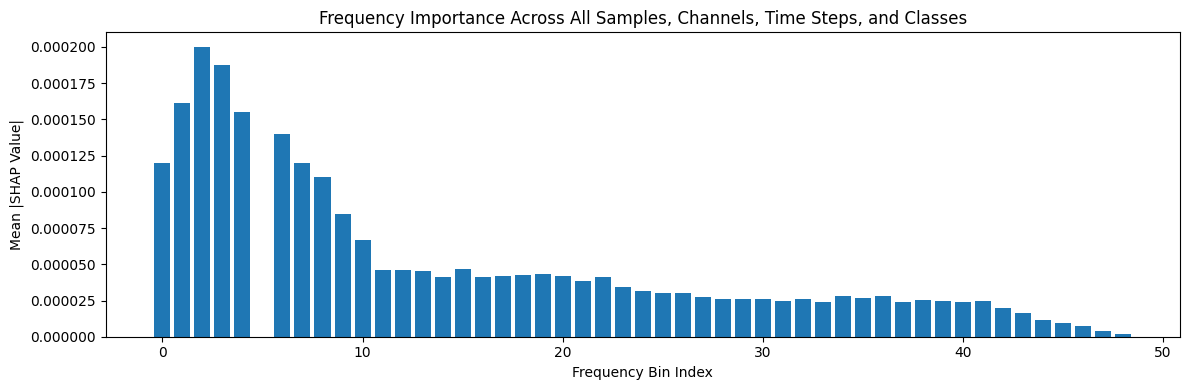

In [27]:
# And using SHAP to try and get feature importance

freq_importance = np.mean(np.abs(shap_values_cnn), axis=(0, 2, 3, 4))

plt.figure(figsize=(12, 4))
plt.bar(range(49), freq_importance)
plt.xlabel("Frequency Bin Index")
plt.ylabel("Mean |SHAP Value|")
plt.title("Frequency Importance Across All Samples, Channels, Time Steps, and Classes")
plt.tight_layout()
plt.show()

In [ ]:
import shap
import numpy as np

# Reshape dimensions
input_shape = (49, 4, 245)
flatten_shape = np.prod(input_shape)

# Wrap model.predict to reshape incoming flat input
def model_predict(X_flat):
    X = X_flat.reshape((-1, *input_shape))  # Reshape to (batch, 49, 4, 245)
    return cnn_lstm_806.predict(X)

# Background dataset (small subset of training data)
X_background = X_train[np.random.choice(X_train.shape[0], 10, replace=False)]
X_background_flat = X_background.reshape((X_background.shape[0], -1))

# Test data to explain
X_test_subset = X_test[:10]  # First 10 samples
X_test_flat = X_test_subset.reshape((X_test_subset.shape[0], -1))

# Initialize KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_background_flat)

# Compute SHAP values (this is slow for large batches)
shap_values = explainer.shap_values(X_test_flat[:1])  # Try [:1] or [:5] first to test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


Notes:

top 3 channels (76, 77, 79) all seem vitally important for classification

even within top 10 importance drops quickly.

channel 9 showed up, seemed out of place, accuracy actually went up when it was not included?? Very curious if this channel gets deleted by Luca's code

# PCA on Parameters

PCA Result Shape: (9, 3)
Explained variance ratio: [0.18779026 0.16762981 0.14197756]


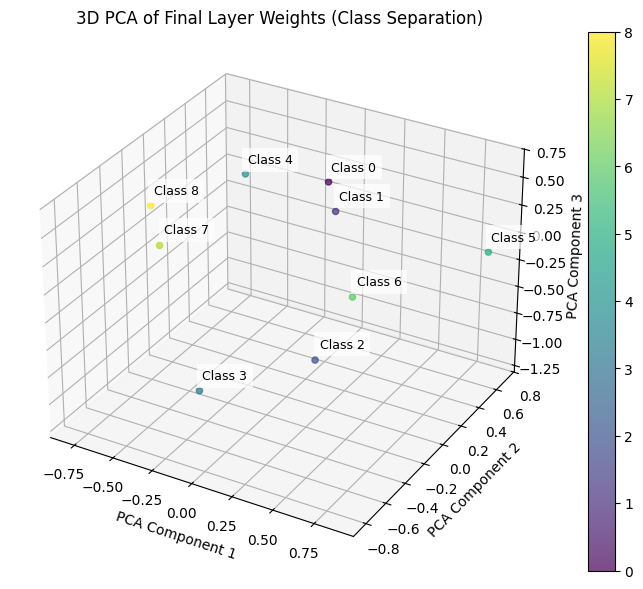

In [ ]:
# PCA on model parameters
def model_PCA(model):
  class_labels = [f"Class {i}" for i in range(9)]

  parallel_model = model.get_layer("ConvClassifier")

  final_layer = parallel_model.layers[-1]  # Last layer (typically classification)
  final_layer_weights = final_layer.get_weights()[0]  # Only weights, not biases

  # Each row is the weight vector for one class (transpose if necessary)
  #model_parameters = final_layer_weights.reshape(final_layer_weights.shape[0], -1)
  model_parameters = final_layer_weights.T


  # Perform PCA on these class weight vectors
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(model_parameters)
  print("PCA Result Shape:", pca_result.shape)  # (num_classes, 3)
  print("Explained variance ratio:", pca.explained_variance_ratio_)

  # Visualizing in 3D
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')
  sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                  c=np.arange(pca_result.shape[0]), cmap='viridis', alpha=0.7)

  offset = 0.1
  for i, label in enumerate(class_labels):
      ax.text(
          pca_result[i, 0] + offset, pca_result[i, 1] + offset, pca_result[i, 2] + offset,  # Coordinates
          label,                                                  # Text label
          fontsize=9,
          ha='center', va='center',
          bbox=dict(facecolor='white', alpha=0.7, lw=0)           # Optional: white background
      )
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')
  ax.set_title('3D PCA of Final Layer Weights (Class Separation)')
  plt.colorbar(sc)
  plt.show()